In [1]:
import os.path
import glob
import pandas as pd
from biom import Table, load_table

import warnings

from qiime2.plugins.feature_table.methods import (rarefy, filter_samples, filter_features,
                                                  merge, relative_frequency, filter_features_conditionally,
                                                 group)

from qiime2.plugins.feature_table.visualizers import summarize

from qiime2 import Artifact
from qiime2 import Metadata


from skbio import OrdinationResults, TreeNode, DistanceMatrix
from qiime2.plugins.gemelli.actions import (rpca, phylogenetic_rpca_without_taxonomy,
                                            phylogenetic_rpca_with_taxonomy)
from qiime2.plugins.emperor.actions import plot, biplot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.pipelines import (alpha,
                                                alpha_phylogenetic)
from qiime2.plugins.diversity.visualizers import (alpha_rarefaction,adonis,beta_group_significance)
from qiime2.plugins.diversity.methods import pcoa
from qiime2.plugins import taxa

from qiime2.plugins import emperor
from qiime2.plugins.empress.actions import community_plot

from assets.step_wise_anova import run_stepwise_anova

from skbio.stats.distance import permanova, bioenv
import statsmodels.stats.multitest as multi 
from scipy.optimize import curve_fit
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import re

In [2]:
# classifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import (roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
# stats
from statsmodels.stats.contingency_tables import mcnemar

# Importing files

In [3]:
# Genome coverages were calculated using Zebra tool across all metagenomic surface samples
# https://github.com/biocore/zebra_filter

# Genome coverages were calculated for two reference databases Web of Life release 2, and RefSeq release 210


In [4]:
wol_coverages = pd.read_csv('./metadata/WoLr2_coverages.tsv',sep='\t')

In [5]:
rs210_coverages = pd.read_csv('./metadata/rep210_coverages.tsv',sep='\t')

In [6]:
# List of human viruses was obtained from RefSeq 
# by selection for viruses that infect Homo sapiens (human) hosts. 

In [7]:
human_viruses = pd.read_csv('./metadata/human_host_viruses.txt',sep='\t')

In [8]:
rs210_meta = pd.read_csv('./metadata/rs210_assembly.tsv',sep='\t')

In [9]:
rs210_meta['organism_name'] = rs210_meta['organism_name'].str.lower()
rs210_meta.drop_duplicates(subset='organism_name',keep='first',inplace=True)

In [10]:
human_viruses['Genome'] = human_viruses['Genome'].astype(str).str.lower()
human_viruses = human_viruses.merge(rs210_meta,left_on='Genome',right_on='organism_name',how='inner',validate='one_to_one')

In [11]:
# Our rs210 database only overlaps with 348 viruses in the human_host_viruses.txt file
human_viruses

,Genome,Accession,RefSeq type,Source information,Number of segments,Genome length,Number of proteins,Genome Neighbors,Host,Date completed,...,seq_rel_date,asm_name,submitter,gbrs_paired_asm,paired_asm_comp,ftp_path,excluded_from_refseq,relation_to_type_material,asm_not_live_date,category
0,adult diarrheal rotavirus strain j19,-,complete,strain:J19,11,17961 nt,11,-,"human, vertebrates",11/2/05,...,2005/11/02,ViralMultiSegProj16144,NaN,GCA_000864245.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV species exemplar,na,viral
1,aichivirus b,NC_004421,complete,strain:U-1,-,8374 nt,1,15,"human, vertebrates",11/18/02,...,2002/11/18,ViralProj14948,NaN,GCA_000853805.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV species exemplar,na,viral
2,akhmeta virus,NC_055230,complete,isolate:Akhmeta_2013-88,-,221923 nt,220,-,"human, vertebrates",6/1/21,...,2021/06/01,ASM645203v1,NaN,GCA_006452035.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV species exemplar,na,viral
3,alenquer virus,-,complete,-,3,12455 nt,4,-,human,6/1/21,...,2021/06/01,ASM1308638v1,NaN,GCA_013086385.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV species exemplar,na,viral
4,alphapapillomavirus 3,NC_001694,complete,-,-,7989 nt,7,51,human,10/18/95,...,1995/10/18,ViralProj15451,NaN,GCA_000862805.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV species exemplar,na,viral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,rhinovirus b14,NC_001490,complete,-,-,7212 nt,1,163,human,8/2/93,...,1993/08/02,ViralProj15309,NaN,GCA_000861265.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV additional isolate,na,viral
344,rhinovirus b3,NC_038312,complete,serotype:3,-,7208 nt,1,163,human,8/24/18,...,2018/08/24,ASM281685v1,NaN,GCA_002816855.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV species exemplar,na,viral
345,rosavirus a2,NC_024070,complete,strain:GA7403,-,8931 nt,1,-,"human, vertebrates",5/5/14,...,2014/05/05,ViralProj246130,NaN,GCA_000918175.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV additional isolate,na,viral
346,sandfly fever turkey virus,-,complete,strain:Izmir 19,3,12603 nt,4,-,"human, invertebrates",4/26/11,...,2011/04/26,ViralMultiSegProj66185,NaN,GCA_000891955.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,ICTV species exemplar,na,viral


In [12]:
human_viruses_hits = human_viruses.merge(rs210_coverages,left_on='genome',right_on='gotu',how='left')

In [13]:
human_viruses_hits['coverage_ratio'] = human_viruses_hits['coverage_ratio'].fillna(0)

In [14]:
human_viruses_hits['Genome Coverage (%)'] = human_viruses_hits['coverage_ratio']*100

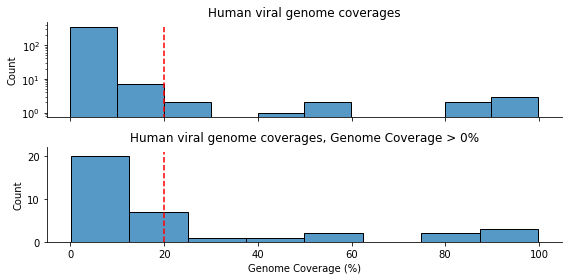

In [15]:
#Figure for reviewer
f, (ax1,ax2) = plt.subplots(nrows=2,figsize=(8,4),sharex=True)
ax2.spines[['right', 'top']].set_visible(False)
ax1.spines[['right', 'top']].set_visible(False)
sns.histplot(human_viruses_hits['Genome Coverage (%)'],ax=ax1)
ax1.set_title('Human viral genome coverages')
min_ = ax1.get_ylim()[0]
max_ = ax1.get_ylim()[1]
ax1.vlines(20, min_, max_,linestyle='dashed',color='red')
ax1.set_yscale('log')
sns.histplot(human_viruses_hits.loc[human_viruses_hits['Genome Coverage (%)']>0]['Genome Coverage (%)'])
min_ = ax2.get_ylim()[0]
max_ = ax2.get_ylim()[1]
ax2.set_title('Human viral genome coverages, Genome Coverage > 0%')
ax2.vlines(20, min_, max_,linestyle='dashed',color='red')
plt.tight_layout()

In [16]:
human_viruses_hits.loc[human_viruses_hits['coverage_ratio']>.20][['Genome','organism_name','strain']]

,Genome,organism_name,strain
95,human alphaherpesvirus 1,human alphaherpesvirus 1,Human alphaherpesvirus 1
119,human herpesvirus 4 type 2,human herpesvirus 4 type 2,Human gammaherpesvirus 4
146,human papillomavirus 179,human papillomavirus 179,Gammapapillomavirus 15
152,human papillomavirus 5,human papillomavirus 5,Betapapillomavirus 1
154,human papillomavirus type 161,human papillomavirus type 161,Gammapapillomavirus 19
160,human papillomavirus type 49,human papillomavirus type 49,Betapapillomavirus 3
176,human polyomavirus 6,human polyomavirus 6,Human polyomavirus 6
219,merkel cell polyomavirus,merkel cell polyomavirus,Human polyomavirus 5
221,molluscum contagiosum virus subtype 1,molluscum contagiosum virus subtype 1,Molluscum contagiosum virus
334,human gammaherpesvirus 4,human gammaherpesvirus 4,Human gammaherpesvirus 4


In [17]:
human_viruses_hits_20 = human_viruses_hits.loc[human_viruses_hits['Genome Coverage (%)']>20]

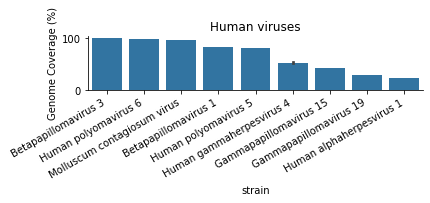

In [18]:
#Figure 6C
f, axes = plt.subplots(nrows=1,figsize=(6,1))
sns.barplot(x='strain',y='Genome Coverage (%)',data=human_viruses_hits_20.sort_values(by='Genome Coverage (%)',
                                                                                   ascending=False),
            color='tab:blue')
axes.spines[['right', 'top']].set_visible(False)
plt.xticks(rotation=30,ha='right',va='top')
plt.title('Human viruses')
plt.savefig('./figs/virus_genome_coverages.svg')

In [19]:
human_viruses_hits_20

,Genome,Accession,RefSeq type,Source information,Number of segments,Genome length,Number of proteins,Genome Neighbors,Host,Date completed,...,excluded_from_refseq,relation_to_type_material,asm_not_live_date,category,gotu,covered_length,total_length,coverage_ratio,strain,Genome Coverage (%)
95,human alphaherpesvirus 1,NC_001806,complete,strain:17; common:Herpes simplex virus type 1,-,152222 nt,77,123,"human, vertebrates",4/3/90,...,NaN,ICTV species exemplar,na,viral,G000859985,36143.0,152222.0,0.237436,Human alphaherpesvirus 1,23.743611
119,human herpesvirus 4 type 2,NC_009334,complete,strain:AG876; common:Epstein-Barr virus type 2,-,172764 nt,80,657,"human, vertebrates",4/3/07,...,NaN,ICTV additional isolate,na,viral,G000872045,89784.0,172764.0,0.519692,Human gammaherpesvirus 4,51.969160
146,human papillomavirus 179,NC_022095,complete,isolate:SIBX16,-,7228 nt,6,5,human,8/14/13,...,NaN,ICTV additional isolate,na,viral,G000912535,3068.0,7228.0,0.424460,Gammapapillomavirus 15,42.446043
152,human papillomavirus 5,NC_001531,complete,-,-,7746 nt,8,11,"human, vertebrates",8/2/93,...,NaN,ICTV species exemplar,na,viral,G000866505,6454.0,7746.0,0.833204,Betapapillomavirus 1,83.320423
154,human papillomavirus type 161,NC_038522,complete,isolate:KC1,-,7238 nt,6,2,human,8/24/18,...,NaN,ICTV species exemplar,na,viral,G002826985,2099.0,7238.0,0.289997,Gammapapillomavirus 19,28.999724
160,human papillomavirus type 49,NC_001591,complete,-,-,7560 nt,6,1,human,8/22/93,...,NaN,ICTV species exemplar,na,viral,G000862825,7548.0,7560.0,0.998413,Betapapillomavirus 3,99.841270
176,human polyomavirus 6,NC_014406,complete,isolate:607a,-,4926 nt,5,17,human,8/16/10,...,NaN,ICTV species exemplar,na,viral,G000888495,4888.0,4926.0,0.992286,Human polyomavirus 6,99.228583
219,merkel cell polyomavirus,NC_010277,complete,isolate:R17b,-,5387 nt,4,73,human,1/21/08,...,NaN,ICTV species exemplar,na,viral,G000874865,4362.0,5387.0,0.809727,Human polyomavirus 5,80.972712
221,molluscum contagiosum virus subtype 1,NC_001731,complete,-,-,190289 nt,163,15,"human, vertebrates",8/15/96,...,NaN,ICTV species exemplar,na,viral,G000843325,184720.0,190289.0,0.970734,Molluscum contagiosum virus,97.073399
334,human gammaherpesvirus 4,NC_007605,complete,strain:B95-8; strain:Raji; type:1,-,171823 nt,94,657,"human, vertebrates",10/9/02,...,NaN,ICTV species exemplar,na,viral,G002402265,92864.0,171823.0,0.540463,Human gammaherpesvirus 4,54.046315


In [20]:
#subsets coverage dataframe to ESKAPE pathogens
ESKAPE = 'Klebsiella pneumoniae|Enterococcus faecium|Acinetobacter baumannii|Staphylococcus aureus|Pseudomonas aeruginosa|Enterobacter bugandensis'
eskape_hits = wol_coverages.loc[wol_coverages['strain'].str.contains(ESKAPE)].sort_values(by='coverage_ratio',ascending=False)
for i in eskape_hits.index:
    strain = eskape_hits.loc[i,'strain'].split(';')[-1]
    eskape_hits.loc[i,'strain2']=strain.replace('s__ ','')
eskape_hits['Genome Coverage (%)'] = eskape_hits['coverage_ratio']*100

In [21]:
eskape_hits

,gotu,covered_length,total_length,coverage_ratio,strain,strain2,Genome Coverage (%)
15,G001066585,4790341,5356759,0.894261,d__Bacteria; p__ Proteobacteria; c__ Gammaprot...,Klebsiella pneumoniae,89.426106
10,G000240185,4961360,5682442,0.873104,d__Bacteria; p__ Proteobacteria; c__ Gammaprot...,Klebsiella pneumoniae,87.310350
812,G008033425,320428,494108,0.648498,d__Bacteria; p__ Proteobacteria; c__ Gammaprot...,Klebsiella pneumoniae,64.849790
96,G009727125,2629179,7460093,0.352432,d__Bacteria; p__ Proteobacteria; c__ Gammaprot...,Pseudomonas aeruginosa,35.243247
158,G000615525,2249268,6521371,0.344907,d__Bacteria; p__ Proteobacteria; c__ Gammaprot...,Pseudomonas aeruginosa,34.490723
475,G001456215,916622,2709797,0.338262,d__Bacteria; p__ Firmicutes; c__ Bacilli; o__ ...,Staphylococcus aureus,33.826224
470,G003309745,938016,3045493,0.308001,d__Bacteria; p__ Firmicutes; c__ Bacilli; o__ ...,Staphylococcus aureus,30.800136
246,G004796175,1788397,6049976,0.295604,d__Bacteria; p__ Proteobacteria; c__ Gammaprot...,Pseudomonas aeruginosa,29.560398
488,G004352345,868463,2975782,0.291844,d__Bacteria; p__ Proteobacteria; c__ Gammaprot...,Pseudomonas aeruginosa,29.184362
508,G004351935,800769,2867548,0.279252,d__Bacteria; p__ Proteobacteria; c__ Gammaprot...,Pseudomonas aeruginosa,27.925217


In [22]:
#cleans up Species names
eskape_hits.loc[eskape_hits['strain2']==' Pseudomonas aeruginosa_A','strain2']=' Pseudomonas aeruginosa'

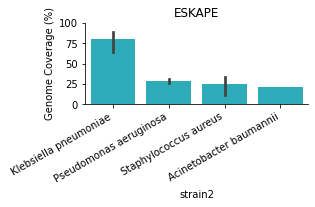

In [23]:
#Figure 6F
f, axes = plt.subplots(nrows=1,figsize=(4,1.5))
sns.barplot(x='strain2',y='Genome Coverage (%)',data=eskape_hits,color='tab:cyan')
plt.ylabel('Genome Coverage (%)')
plt.xticks(rotation=30,ha='right')
plt.ylim(0,100)
axes.spines[['right', 'top']].set_visible(False)
plt.title('ESKAPE')
plt.savefig('./ESKAPE_hits.svg')

In [24]:
# Genome coverage depth was calculated using samtools
# samtools depth ./sample.alignment.sam > ./sample_coverages.txt
# coverage depth for target genomes (G000240185) were extracted from sample_coverages.txt file

In [25]:
kleb_1 = pd.read_csv('./data/G000240185.txt',sep='\t',header=None)

In [26]:
kleb_1.sort_values(by=1)

,0,1,2
0,G000240185,3,2
1,G000240185,4,2
2,G000240185,5,2
3,G000240185,6,2
4,G000240185,7,2
...,...,...,...
4629901,G000240185,5680868,7
4629902,G000240185,5680869,6
4629903,G000240185,5680870,6
4629904,G000240185,5680871,4


In [27]:
# Genome length for G000240185 = 5682442, Klebsiella pneumoniae
# 4629906 covered bases
(4629906/5682442)*100

81.47740003329554

In [28]:
depth = np.zeros(5682442)
for i in kleb_1.index:
    depth[kleb_1.loc[i,1]]=kleb_1.loc[i,2]
    

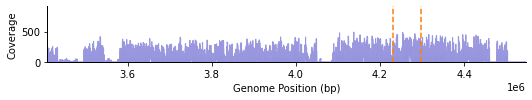

In [29]:
# Figure 6G
genome_strain = 's__ Klebsiella pneumoniae'
genome_split = 5
split_bin_size = int(len(depth)/genome_split)
f, axes = plt.subplots(nrows=1,figsize=(7.5,1.5))
for split in range(genome_split):
    if split == 3:
        slice_ = depth[split*split_bin_size:(split+1)*split_bin_size]
        axes.fill_between(range(split*split_bin_size,(split+1)*split_bin_size), slice_, color="skyblue", alpha=0.2)
        axes.plot(range(split*split_bin_size,(split+1)*split_bin_size), slice_, color="Slateblue", alpha=0.6,linewidth=1.0,)
        axes.set_ylabel('Coverage')
        axes.set_ylim(0,depth.max())
        axes.set_xlim(split*split_bin_size,(split+1)*split_bin_size)
        axes.set_xlabel('Genome Position (bp)')
    else:
        continue
genome_coverage = sum(depth>0)/len(depth) * 100
axes.set_title(None)
axes.axvline((4230447),0,depth.max(),color="tab:orange",linestyle='--')
axes.axvline((4298217),0,depth.max(),color="tab:orange",linestyle='--')
plt.tight_layout()
# Hide the right and top spines
axes.spines[['left', 'bottom']].set_linewidth(1)
axes.spines[['right', 'top']].set_visible(False)
            
plt.savefig('./figs/kleb_genome_cov_exclusive.png')

In [30]:
# Genome coverage depth was calculated using samtools
# samtools depth ./sample.alignment.sam > ./sample_coverages.txt
# coverage depth for target genomes (G000862825) were extracted from sample_coverages.txt file

In [31]:
hpv_3 = pd.read_csv('./data/G000862825.txt',sep='\t',header=None)

In [32]:
hpv_3

,0,1,2
0,G000862825,13,9
1,G000862825,14,9
2,G000862825,15,9
3,G000862825,16,69
4,G000862825,17,69
...,...,...,...
7526,G000862825,7556,17
7527,G000862825,7557,17
7528,G000862825,7558,17
7529,G000862825,7559,17


In [33]:
# Genome length for G000240185 = 7561, Betapapillomavirus 3
# 7531 covered bases
(7531/7561)*100

99.60322708636423

In [34]:
depth_hpv_3 = np.zeros(7561)
for i in hpv_3.index:
    depth_hpv_3[hpv_3.loc[i,1]]=hpv_3.loc[i,2]
    

In [35]:
def smooth_cov_plot(cov_array,smooth_window_len):
    array_len = len(cov_array)
    total_bins = (array_len//smooth_window_len)+1
    smooth_df = pd.DataFrame(index=range(total_bins))
    start_i=0
    for bin_ in range(total_bins):
        end_i=(bin_+1)*smooth_window_len
        smooth_value = np.median(cov_array[start_i:end_i])
        smooth_df.loc[bin_,'smooth_cov']=smooth_value
        start_i=end_i
    return(smooth_df)

In [36]:
binned_depth_hpv_3 =  smooth_cov_plot(depth_hpv_3,100)

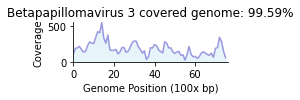

In [37]:
#Figure 6D
genome_strain = 'Betapapillomavirus 3'
genome_split = 1
split_bin_size = int(len(binned_depth_hpv_3)/genome_split)
f, axes = plt.subplots(nrows=genome_split,figsize=(3,1.5))
for split in range(genome_split):
    slice_ = binned_depth_hpv_3.to_numpy().flatten()[split*split_bin_size:(split+1)*split_bin_size]
    axes.fill_between(range(split*split_bin_size,(split+1)*split_bin_size), slice_, color="skyblue", alpha=0.2)
    axes.plot(range(split*split_bin_size,(split+1)*split_bin_size), slice_, color="Slateblue", alpha=0.6)
    axes.set_ylabel('Coverage')
    axes.set_ylim(0,binned_depth_hpv_3.to_numpy().flatten().max())
    axes.set_xlim(split*split_bin_size,(split+1)*split_bin_size)
    axes.set_xlabel('Genome Position (100x bp)')
genome_coverage = sum(depth_hpv_3>0)/len(depth_hpv_3) * 100
axes.set_title(f'{genome_strain} covered genome: {genome_coverage:.2f}%')
axes.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('./figs/papilomav_genome_cov.svg')

In [38]:
HPyV6 = pd.read_csv('./data/G000888495.txt',sep='\t',header=None)

In [39]:
HPyV6

,0,1,2
0,G000888495,17,5
1,G000888495,18,5
2,G000888495,19,5
3,G000888495,20,5
4,G000888495,21,5
...,...,...,...
4711,G000888495,4900,10
4712,G000888495,4901,10
4713,G000888495,4902,10
4714,G000888495,4903,10


In [40]:
# Genome length for G000240185 = 7561, Betapapillomavirus 3
# 4716 covered bases
(4716/4926)*100

95.73690621193667

In [41]:
depth_HPyV6 = np.zeros(4926)
for i in HPyV6.index:
    depth_HPyV6[HPyV6.loc[i,1]]=HPyV6.loc[i,2]
    

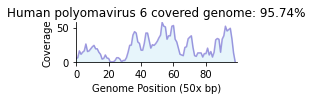

In [42]:
# Figure 6E
smooth_len = 50
binned_depth_HPyV6 =  smooth_cov_plot(depth_HPyV6,smooth_len)


genome_strain = 'Human polyomavirus 6'
genome_split = 1
split_bin_size = int(len(binned_depth_HPyV6)/genome_split)
f, axes = plt.subplots(nrows=genome_split,figsize=(3,1.5))
for split in range(genome_split):
    slice_ = binned_depth_HPyV6.to_numpy().flatten()[split*split_bin_size:(split+1)*split_bin_size]
    axes.fill_between(range(split*split_bin_size,(split+1)*split_bin_size), slice_, color="skyblue", alpha=0.2)
    axes.plot(range(split*split_bin_size,(split+1)*split_bin_size), slice_, color="Slateblue", alpha=0.6)
    axes.set_ylabel('Coverage')
    axes.set_ylim(0,binned_depth_HPyV6.to_numpy().flatten().max())
    axes.set_xlim(split*split_bin_size,(split+1)*split_bin_size)
    axes.set_xlabel(f'Genome Position ({smooth_len}x bp)')
genome_coverage = sum(depth_HPyV6>0)/len(depth_HPyV6) * 100
axes.set_title(f'{genome_strain} covered genome: {genome_coverage:.2f}%')
axes.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('./figs/polyomavirus_genome_cov.svg')